# Dictionary Learning

In [147]:
import cv2 as cv
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import DictionaryLearning
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage.util import view_as_windows
from skimage.metrics import structural_similarity as ssim

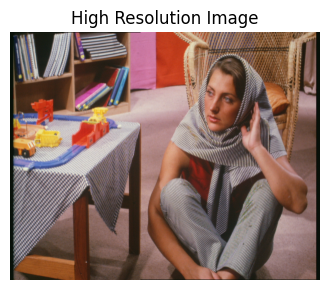

Shape of Image: (576, 720, 3)


In [131]:
#Load an sample Image 
img_loc = "/Users/ltc/Documents/Python Scripts/MTP/Set14/original/barbara.png"
high_res_img = mpimg.imread(img_loc)
#Display the image
plt.figure(figsize=(4,8))
plt.imshow(high_res_img)
plt.axis("off")
plt.title("High Resolution Image")
plt.show()

print(f"Shape of Image: {high_res_img.shape}")

## Low Resolution Image

1. First, a kernel size of (5,5) is defined for Gaussian blur. Then, the high-resolution image is blurred using OpenCV's GaussianBlur function with the defined kernel size and a sigma value of 1. This step smooths out the image and reduces the high-frequency noise.

2. Next, the blurred image is resized using OpenCV's resize function. Here, the image is downscaled to half its original size in both dimensions (fx=0.5, fy=0.5). The resulting image will be a low-resolution version of the original high-resolution image.

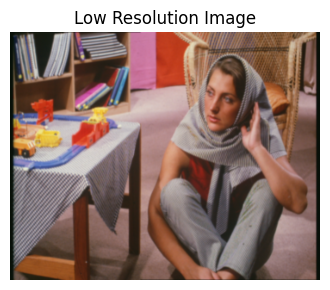

Shape of Image: (288, 360, 3)


In [132]:
#Low resolution image(Guassian blur --> down-sampling)
kernel = (5,5)
blur_img = cv.GaussianBlur(high_res_img,kernel, 1)

low_res_img = cv.resize(blur_img, (0,0),fx=0.5, fy=0.5)
#Display the image
plt.figure(figsize=(4,8))
plt.imshow(low_res_img)
plt.axis("off")
plt.title("Low Resolution Image")
plt.show()

print(f"Shape of Image: {low_res_img.shape}")

In [4]:
#Pre Processing the image

#Apply gamma correction


## GreyScale Image

Rather than learning three differnet dictionaries for three separate channel, we will work with grey scale version of the image.

In [133]:
#Grey scale image of high res image
grey_high_res = cv.cvtColor(high_res_img, cv.COLOR_RGB2GRAY)

grey_low_res = cv.cvtColor(low_res_img, cv.COLOR_RGB2GRAY)

# grey_low_res = (grey_low_res*255).astype(np.uint8)

#saving low and high resolution gray scale image
# cv.imwrite("Low_res_grey.jpeg", grey_low_res)
# cv.imwrite("High_res_grey.jpeg", grey_high_res)

## Patches

The patch size should be small enough to capture local details and textures in the image, but large enough to ensure that the patches contain enough information to accurately represent the image content.

Normalization of patches is often a good practice before sending them to a dictionary learning algorithm. This is because normalization can help to reduce the influence of scaling and illumination changes on the learned dictionary.

Some common normalization techniques include:


1. Mean normalization: This involves subtracting the mean value of the patch from each pixel value. This ensures that the pixel values have a zero mean, which can be useful for learning sparse representations.

2. Standardization: This involves scaling the pixel values to have a zero mean and unit variance. This can be useful for removing the effects of different scales and ranges of the pixel values.

Calculating the mean and standard deviation of each patch individually is important because it ensures that the normalization is performed on a per-patch basis, rather than on the entire image or a larger subset of the image. This is important because different patches within the image may have different statistical properties, such as different levels of noise or contrast. By calculating the mean and standard deviation of each patch separately, we can ensure that each patch is normalized according to its own statistical properties, rather than being normalized based on the overall properties of the image.

In [134]:
#Extract **Overlaping patches** from High resolution images

#Define patch size
patch_size = (16,16)
#Define step size
step = (8,8)

#Using inbuilt patch extractor

#Single channel patch
patches = view_as_windows(grey_low_res, patch_size, step)

#Multi channel patch
# patches = view_as_windows(low_res_img, patch_size)


#Normalize each patch
n_patches = patches.shape[0]*patches.shape[1]
patches_list = patches.reshape(n_patches, -1)

norm_patches = []
for patch in patches_list:
    mean = np.mean(patch)
    std = np.std(patch)
    if std != 0:
        norm_patches.append((patch - mean)/std)

norm_patches = np.array(norm_patches)

# norm_patches_arr = norm_patches.reshape(-1,patch_size[0], patch_size[1])
# print(norm_patches_arr[0])

print(f"Shape of Patch : {patches.shape}")

Shape of Patch : (35, 44, 16, 16)


## Training Time

For batch of approx 3000 patches of size 16X16 it approx took 4hrs for training

In [7]:
#Applying Dictionary Learning for Low Resolution Image

#init dictionary learning model
#Using 'orthogonal matching pursuit Algorithm'
dl = DictionaryLearning(transform_algorithm='omp', random_state=42, verbose=True)

In [152]:
# dl.fit(norm_patches)

[dict_learning] .5 unused atoms resampled.
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

DictionaryLearning(random_state=42, verbose=True)

In [135]:
#Setting random seed
rng = np.random.seed(42)

In [127]:
%%time
%%capture cap --no-stderr
batch_dl = MiniBatchDictionaryLearning(
    n_components=2048, max_iter=100, batch_size=250, shuffle=True,verbose=True,random_state=rng)

batch_dl.fit(norm_patches)

CPU times: user 4min 16s, sys: 49.9 s, total: 5min 6s
Wall time: 2min 50s


### Grid Search

In [185]:
param_grid = {
    'n_components': [256, 512],
#     'alpha': [0.1, 0.01, 0.05],
    'batch_size': [100],
#     'max_iter': [50, 100]
}

In [186]:
# # Define a custom scoring function that uses silhouette score
# def silhouette_scorer(estimator, X):
#     labels = estimator.fit_predict(X) # Get the cluster labels
#     score = silhouette_score(X, labels) # Compute the silhouette score
#     return score

In [187]:
from sklearn.metrics import mean_squared_error

def reconstruction_error(estimator, X):
    # Fit the estimator to the data
    estimator.fit(X)

    # Compute the reconstruction error
    X_transformed = estimator.transform(X)
    dictionary = estimator.components_
#     X_reconstructed = np.dot(X_transformed, dictionary)
    X_reconstructed = X_transformed @ dictionary
    error = mean_squared_error(X, X_reconstructed)

    # Return the negative reconstruction error (as GridSearchCV tries to maximize the score)
    return -error

In [188]:
estimator = MiniBatchDictionaryLearning()
scoring = 'neg_mean_squared_error'

grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=reconstruction_error,verbose=2)

In [189]:
grid_search.fit(norm_patches)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


[CV] END ...................batch_size=100, n_components=256; total time= 6.1min


/Users/ltc/Documents/Python Scripts/MTP/venv/lib/python3.11/site-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


[CV] END ...................batch_size=100, n_components=256; total time= 6.2min


KeyboardInterrupt: 

In [102]:
#saving the logs to .txt file
with open("Patches.txt", "w") as f:
    f.write(cap.stdout)

In [103]:
#Parsing .txt file 
with open("Patches.txt", "r") as f:
    lines = f.readlines()

with open("Patches.csv", "w") as f_:

    header = ["Minibatch step", "mean batch cost", "ewa cost"]
    writer = csv.DictWriter(f_, fieldnames=header)
    writer.writeheader()
    
    for line in lines[1:]:
        
        if line.startswith("Minibatch"):
            line = line.lower()
            tokens = line.split(": ")
            step_info = tokens[0].split(" ")
            current_step, total_step = step_info[2].split("/")
            try:
                mean = float(tokens[2])
                mean = f"{mean:.2f}"
            except ValueError:
                mean = float(tokens[2].split(",")[0])
                mean = f"{mean:.2f}"
            ewa_mean = None
            if len(tokens) > 3:
                ewa_mean = float(tokens[3].strip())
                ewa_mean = f"{ewa_mean:.2f}"
            writer.writerow({"Minibatch step": current_step, "mean batch cost": mean, "ewa cost":ewa_mean})
    print(f"Successfully Stored as CSV\n")


Successfully Stored as CSV



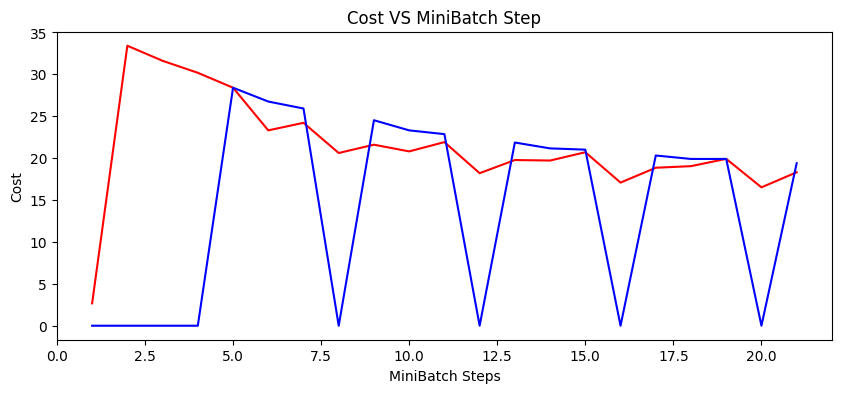

In [104]:
step = []
mean = []
ewa_mean = []
with open("Patches.csv", "r") as f:
    reader = csv.DictReader(f)
    
    for line in reader:
        step.append(float(line["Minibatch step"]))
        mean.append(float(line["mean batch cost"]))
        try: 
            ewa_mean.append(float(line["ewa cost"]))
        except ValueError:
            ewa_mean.append(0)

plt.figure(figsize=(10,4))
plt.plot(step, mean, "r", label="Mean batch cost")
plt.plot(step, ewa_mean, "b", label="EWA cost")
plt.xlabel("MiniBatch Steps")
plt.ylabel("Cost")
plt.title("Cost VS MiniBatch Step")
plt.show()

In [280]:
# #Saving the dl
# import pickle

# dl_pickle = pickle.dumps(dl)

# with open("dl.pickle", "wb") as f:
#     f.write(dl_pickle)

In [279]:
# %store dl

Stored 'dl' (DictionaryLearning)


In [7]:
#loading dl 
%store -r dl

In [8]:
dl.get_params()

{'alpha': 1,
 'code_init': None,
 'dict_init': None,
 'fit_algorithm': 'lars',
 'max_iter': 1000,
 'n_components': None,
 'n_jobs': None,
 'positive_code': False,
 'positive_dict': False,
 'random_state': 42,
 'split_sign': False,
 'tol': 1e-08,
 'transform_algorithm': 'omp',
 'transform_alpha': None,
 'transform_max_iter': 1000,
 'transform_n_nonzero_coefs': None,
 'verbose': True}

In [45]:
#Accessing the dictionary
dictionary = dl.components_
print(f"Shape of Learned Dictionary : {dictionary.shape}")

AttributeError: 'DictionaryLearning' object has no attribute 'components_'

In [105]:
#Accessing the MiniBatch dictionary
dictionary = batch_dl.components_
print(f"Shape of Learned Dictionary : {dictionary.shape}")

Shape of Learned Dictionary : (2048, 256)


Shape of Reshaped Dictionary: (2048, 16, 16)


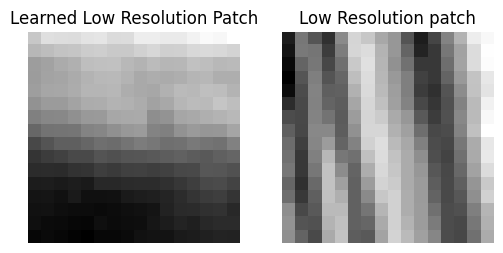

In [112]:
#Changing the shape of learned dictionary to each row representing a 16X16 patch
reshaped_dict = dictionary.reshape(-1, patch_size[0], patch_size[1])
print(f"Shape of Reshaped Dictionary: {reshaped_dict.shape}")


plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(reshaped_dict[1], cmap="gray")
plt.axis("off")
plt.title("Learned Low Resolution Patch")


#Original patch
plt.subplot(1,2,2)
plt.imshow(patches[1][1], cmap="gray")
plt.axis("off")
plt.title("Low Resolution patch")
plt.show()

In [117]:
# Apply dictionary to the sparse codes
X = batch_dl.transform(norm_patches)
print(f'X matrix shape : {X.shape}')
print(f'# of zero entries in the X : {np.sum(X == 0)} \npercentage of zero entries : {np.mean(X == 0)}')

X matrix shape : (1540, 2048)
# of zero entries in the X : 3115420 
percentage of zero entries : 0.98779296875


In [113]:
# Reconstruct patches from sparse codes and dictionary
patches_rec = X @ dictionary
# Reshape the reconstructed patches to their original shape
patches_rec = patches_rec.reshape(patches.shape)

print(patches_rec.shape)

(35, 44, 16, 16)


## Artifact Removal

The line `reconstructed_img /=` count is used to normalize the pixel values in the final reconstructed image.
During the process of combining the patches into the reconstructed image, each pixel location in the image can be updated multiple times by different patches. The count array is used to keep track of the number of times each pixel location is updated.
Dividing reconstructed_img by count effectively takes an average of the values of each pixel location across all the patches that contribute to that pixel location. This helps to smooth out any artifacts or inconsistencies that may have arisen during the patch reconstruction process.
The normalization step ensures that each pixel location in the final image has a value that is representative of the information from all the patches that contribute to that location, and not biased towards any particular patch.

In [120]:
# Combine the patches into the reconstructed image
reconstructed_img = np.zeros(grey_low_res.shape)
count = np.zeros(grey_low_res.shape)

for i in range(patches_rec.shape[0]):
    for j in range(patches_rec.shape[1]):
        patch = patches_rec[i, j]
        y, x = i*step[0], j*step[1]
        reconstructed_img[y:y+patch_size[0], x:x+patch_size[1]] += patch
        count[y:y+patch_size[0], x:x+patch_size[1]] += 1

reconstructed_img /= count

reconstructed_img = np.nan_to_num(reconstructed_img)

TypeError: slice indices must be integers or None or have an __index__ method

In [121]:
# Rescale the pixel values to between 0 and 255
reconstructed_img = (reconstructed_img - reconstructed_img.min()) / (reconstructed_img.max() - reconstructed_img.min()) * 255

# Convert the pixel values to integers
reconstructed_img = reconstructed_img.astype(np.uint8)

/var/folders/sf/2_s8z4pn0kd5rzqz633m85v40000gn/T/ipykernel_4411/2675528230.py:2: RuntimeWarning: invalid value encountered in divide
  reconstructed_img = (reconstructed_img - reconstructed_img.min()) / (reconstructed_img.max() - reconstructed_img.min()) * 255
/var/folders/sf/2_s8z4pn0kd5rzqz633m85v40000gn/T/ipykernel_4411/2675528230.py:5: RuntimeWarning: invalid value encountered in cast
  reconstructed_img = reconstructed_img.astype(np.uint8)


In [122]:
print(reconstructed_img, grey_low_res)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [[0.05467503 0.05423399 0.05399315 ... 0.05010776 0.05058256 0.05124079]
 [0.05503496 0.05426864 0.05383695 ... 0.05029953 0.0504802  0.05121281]
 [0.05435793 0.05304192 0.0533537  ... 0.05006938 0.05029491 0.05103985]
 ...
 [0.0547163  0.05569794 0.05654969 ... 0.05277043 0.05279796 0.05267195]
 [0.0546536  0.05516567 0.0564617  ... 0.05196483 0.05273597 0.05238411]
 [0.0544191  0.05460883 0.05636843 ... 0.05198615 0.05255769 0.05235916]]


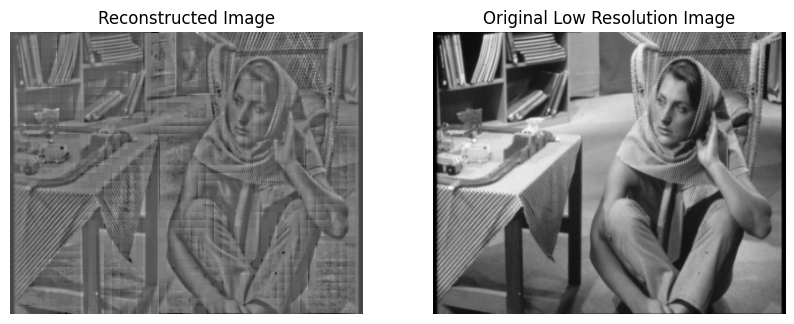

Shape of Original Low Resolution Image: (288, 360)
Shape of Reconstructed Low Resolution Image: (288, 360)


In [79]:
# Display the reconstructed image
plt.figure(figsize=(10,12))
plt.subplot(1,2,1)
plt.imshow(reconstructed_img, cmap="gray")
plt.axis('off')
plt.title('Reconstructed Image')


plt.subplot(1,2,2)
plt.imshow(grey_low_res, cmap="gray")
plt.axis("off")
plt.title("Original Low Resolution Image")
plt.show()

print(f"Shape of Original Low Resolution Image: {grey_low_res.shape}")
print(f"Shape of Reconstructed Low Resolution Image: {reconstructed_img.shape}")

## SSIM
SSIM measures the structural similarity between two images, taking into account luminance, contrast, and structure. A higher SSIM score indicates a higher level of similarity between the two images.

In [81]:
# Calculate the SSIM between the reconstructed and original images
ssim_score = ssim(grey_low_res, reconstructed_img)

# Print the SSIM score
print(f"SSIM score between Reconstructed and Original: {ssim_score:.2f}")

SSIM score between Reconstructed and Original: 0.74


# Another Approach

Using Lasso(Linear Regression and L1 norm) 

In [82]:
from sklearn.linear_model import Lasso
from skimage.io import imread, imsave

In [83]:
#Extract **Overlaping patches** from High resolution images

#Define patch size
patch_size = (16,16)
#Define step size
step = (8,8)

#Using inbuilt patch extractor

#Single channel patch
patches = view_as_windows(grey_low_res, patch_size, step)

#Normalize each patch
n_patches = patches.shape[0]*patches.shape[1]
patches_list = patches.reshape(n_patches, -1)

norm_patches = []
for patch in patches_list:
    mean = np.mean(patch)
    std = np.std(patch)
    if std != 0:
        norm_patches.append((patch - mean)/std)

norm_patches = np.array(norm_patches)

# norm_patches_arr = norm_patches.reshape(-1,patch_size[0], patch_size[1])
# print(norm_patches_arr[0])

print(f"Shape of Patch : {patches.shape}")

Shape of Patch : (35, 44, 16, 16)


## Training Time

For same batch of patches it took approx 5mins for the model to converge to a minima

In [84]:
# Perform sparse coding using Lasso
alpha = 0.1  # regularization parameter
lasso = Lasso(alpha=alpha)
lasso.fit(norm_patches.T, norm_patches.T)
coef = lasso.coef_

In [23]:
patches.shape

(40, 73, 16, 16)

In [85]:
# Reconstruct image from sparse codes
patches_rec = np.dot(coef.T, norm_patches)
patches_rec = patches_rec.reshape(patches.shape)

In [86]:
# Combine the patches into the reconstructed image
reconstructed_img_2 = np.zeros(grey_low_res.shape)
count = np.zeros(grey_low_res.shape)

for i in range(patches_rec.shape[0]):
    for j in range(patches_rec.shape[1]):
        patch = patches_rec[i, j]
        y, x = i*step[0], j*step[1]
        reconstructed_img_2[y:y+patch_size[0], x:x+patch_size[1]] += patch
        count[y:y+patch_size[0], x:x+patch_size[1]] += 1

reconstructed_img_2 /= count

reconstructed_img_2 = np.nan_to_num(reconstructed_img_2)

In [87]:
# Rescale the pixel values to between 0 and 255
reconstructed_img_2 = (reconstructed_img_2 - reconstructed_img_2.min()) / (reconstructed_img_2.max() - reconstructed_img_2.min()) * 255

# Convert the pixel values to integers
reconstructed_img_2 = reconstructed_img_2.astype(np.uint8)

In [27]:
#Saving the image
# cv.imwrite("reconstructed2.jpeg", reconstructed_img_2)

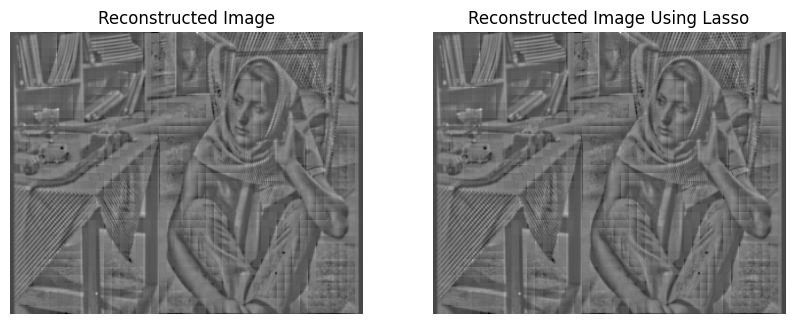

In [88]:
plt.figure(figsize=(10,12))
plt.subplot(1,2,1)
plt.imshow(reconstructed_img, cmap="gray")
plt.axis('off')
plt.title('Reconstructed Image')


plt.subplot(1,2,2)
plt.imshow(reconstructed_img_2, cmap="gray")
plt.axis("off")
plt.title("Reconstructed Image Using Lasso")
plt.show()

In [90]:
# Calculate the SSIM between the reconstructed and original images
ssim_score = ssim(reconstructed_img, reconstructed_img_2)

# Print the SSIM score
print(f"SSIM score between Reconstructed Image using DL and LASSO: {ssim_score:.2f}")

SSIM score between Reconstructed Image using DL and LASSO: 1.00


In [31]:
image1 = Image.open('Low_res_grey.jpeg')
image2 = Image.open('reconstructed2.jpeg')

In [92]:
# Calculate the SSIM between the reconstructed and original images
ssim_score = ssim(reconstructed_img_2, grey_low_res)

# Print the SSIM score
print(f"SSIM score between Reconstructed Image using LASSO and Original: {ssim_score:.2f}")

SSIM score between Reconstructed Image using LASSO and Original: 0.74
